LIBRARIES

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

DATASET KAGGLE

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!gdown --id 1kgNGfbDvzO9IDf5_NuFs8MDxTudBdTug

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kgNGfbDvzO9IDf5_NuFs8MDxTudBdTug
To: /content/kaggle.json
100% 70.0/70.0 [00:00<00:00, 136kB/s]


In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download montalvorafael/ecuadorianfood

 86% 25.0M/29.1M [00:01<00:00, 32.8MB/s]
100% 29.1M/29.1M [00:01<00:00, 22.8MB/s]


In [ ]:
! unzip ecuadorianfood.zip

Archive:  ecuadorianfood.zip
  inflating: IADataSet/Bolon/4-image_web.jpg  
  inflating: IADataSet/Bolon/553311ceb92f8c1fb28ff76ba72efccd_xl.jpg  
  inflating: IADataSet/Bolon/BolC3B3n20de20verde20con20queso20y20chicharrC3B3n20-20Pinteres.jpg  
  inflating: IADataSet/Bolon/Bolon-de-Verde-ecuatoriano.jpg  
  inflating: IADataSet/Bolon/Bolon-de-verde-ecuatoriano-shutterstock_2176275111.jpg  
  inflating: IADataSet/Bolon/R-2-1.jpg  
  inflating: IADataSet/Bolon/RLTOWJW5FVGYVPOOVVNJDZTPWI.jpg  
  inflating: IADataSet/Bolon/bolon-de-verde-ecuatoriano-500x500.jpg  
  inflating: IADataSet/Bolon/bolon-de-verde-ecuatoriano-900.jpg  
  inflating: IADataSet/Bolon/bolon_mixto.jpg  
  inflating: IADataSet/Bolon/bolon_mixto_1a.jpg  
  inflating: IADataSet/Bolon/bolones-1.jpg  
  inflating: IADataSet/Bolon/bolones-mixtos.jpg  
  inflating: IADataSet/Bolon/c33a10f623d5e94cdef6f63776408547_xl.jpg  
  inflating: IADataSet/Bolon/fotonoticia_20161216072739_1200.jpg  
  inflating: IADataSet/Bolon/hqdefault

In [ ]:
import pathlib
data = pathlib.Path('/content/IADataSet')

In [ ]:
image_count = len(list(data.glob('*/*.jpg')))
print(image_count)

548


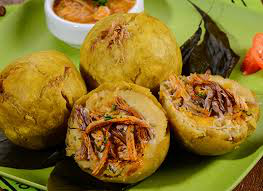

In [ ]:
bolon = list(data.glob('Bolon/*'))
PIL.Image.open(str(bolon[0]))

PRE PROCESAMIENTO

In [ ]:
batch_size = 32
# antes
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 548 files belonging to 4 classes.
Using 439 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 548 files belonging to 4 classes.
Using 109 files for validation.


CLASES

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bolon', 'Encebollado', 'Fritada', 'SecoPollo']


Verificacion de tipos de archivos

In [ ]:
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

VISUALIZACION DE LA DATA

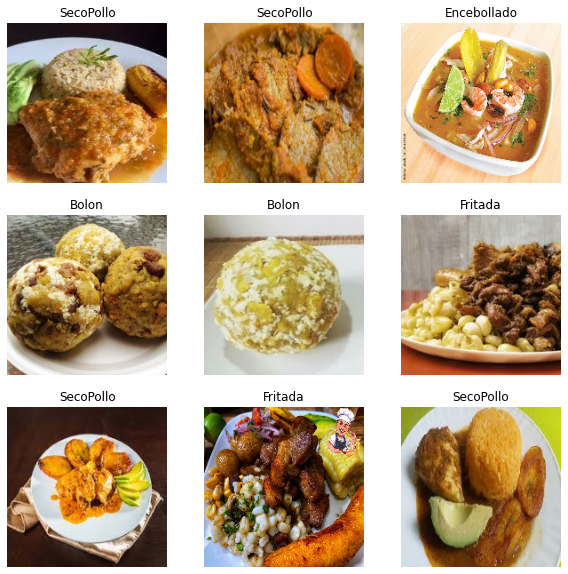

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

CONFIGURE DATA SET

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Los valores de los píxel ahora están en `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


MODELO

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MODEL SUMMARY

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

MODEL TRAINING

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 13s 853ms/step - loss: 1.5104 - accuracy: 0.2802 - val_loss: 1.3749 - val_accuracy: 0.3211
Epoch 2/10
14/14 [==============================] - 13s 907ms/step - loss: 1.3469 - accuracy: 0.3508 - val_loss: 1.2965 - val_accuracy: 0.4954
Epoch 3/10
14/14 [==============================] - 11s 819ms/step - loss: 1.1576 - accuracy: 0.5125 - val_loss: 1.0960 - val_accuracy: 0.5413
Epoch 4/10
14/14 [==============================] - 12s 826ms/step - loss: 0.8954 - accuracy: 0.6492 - val_loss: 0.9810 - val_accuracy: 0.6422
Epoch 5/10
14/14 [==============================] - 11s 818ms/step - loss: 0.5837 - accuracy: 0.8178 - val_loss: 0.8385 - val_accuracy: 0.6789
Epoch 6/10
14/14 [==============================] - 11s 801ms/step - loss: 0.4557 - accuracy: 0.8292 - val_loss: 0.7403 - val_accuracy: 0.7523
Epoch 7/10
14/14 [==============================] - 11s 805ms/step - loss: 0.2645 - accuracy: 0.9339 - val_loss: 0.9374 - val_accuracy: 0.6972

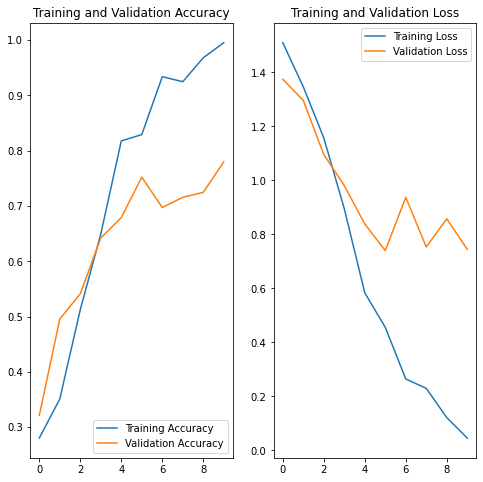

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

OVERFITTING

DATA AUGMENTATION

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

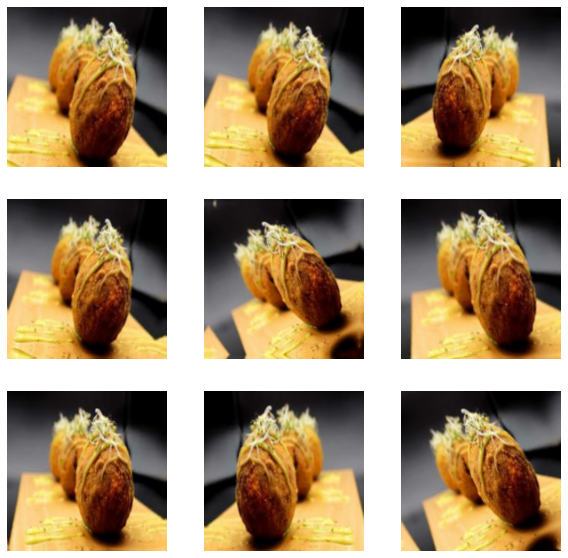

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

DROPOUT

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

RE-TRAINING

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
14/14 [==============================] - 14s 963ms/step - loss: 1.7202 - accuracy: 0.2597 - val_loss: 1.3753 - val_accuracy: 0.2569
Epoch 2/40
14/14 [==============================] - 12s 882ms/step - loss: 1.3723 - accuracy: 0.2938 - val_loss: 1.3682 - val_accuracy: 0.2569
Epoch 3/40
14/14 [==============================] - 12s 886ms/step - loss: 1.2988 - accuracy: 0.3690 - val_loss: 1.2292 - val_accuracy: 0.5229
Epoch 4/40
14/14 [==============================] - 12s 882ms/step - loss: 1.1546 - accuracy: 0.4738 - val_loss: 1.1546 - val_accuracy: 0.4587
Epoch 5/40
14/14 [==============================] - 12s 878ms/step - loss: 1.0892 - accuracy: 0.5421 - val_loss: 1.0533 - val_accuracy: 0.5505
Epoch 6/40
14/14 [==============================] - 12s 885ms/step - loss: 0.9949 - accuracy: 0.5945 - val_loss: 0.9661 - val_accuracy: 0.6606
Epoch 7/40
14/14 [==============================] - 12s 887ms/step - loss: 0.9033 - accuracy: 0.6287 - val_loss: 0.9570 - val_accuracy: 0.6697

RESULTS

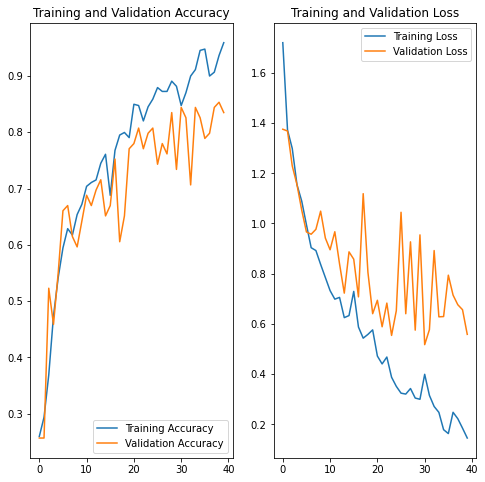

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

TESTING

In [ ]:
img = tf.keras.utils.load_img(
    bolon[2], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta imagen pertenece a {} con un {:.2f} por ciento."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 174ms/step
Esta imagen pertenece a Bolon con un 91.15 por ciento.


In [ ]:
tf.keras.models.save_model(model,'my_model2.hdf5')

APP

In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
!pip install protobuf==3.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
googleapis-common-protos 1.58.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-translate 3.8.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-c

In [ ]:
!pip install requests-html
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.8 MB/s eta 0:00:00
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=79e6eb8a5329c6cb89f0e1f926d70a062589d2cbc941108d93eaaffe7c5a34a4
  Stored in directory: /root/.cache/pip/wheels/e5/33/1f/68392720485b3ecf125a69e700baaab7624616deedea2fa6e2
Successfully built parse
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from requests_html import HTMLSession
import matplotlib.pyplot as plt
import pandas as pd

def get_data(in_result):
    if in_result != -1:
        api_url = f"https://restapi-ia-2022.onrender.com/info/{in_result}"
    else:
       st.warning('La foto no es bolón, ni encebollado, ni seco de pollo, ni fritada', icon="⚠️")
    info_json = sess.get(api_url).json()
    return info_json

@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Comida Ecuatoriana Classification
         """
         )

file = st.file_uploader("Carga una imagen de comida ecuatoriana", type=["jpg", "png", "jpeg"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (180,180)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        img = np.asarray(image)

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Por favor cargue una imagen")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    class_names = ['Bolon', 'Encebollado', 'Fritada', 'SecoPollo']
    string = "Esta imagen pertenece a: "+ class_names[np.argmax(score)]
    st.success(string)
    resultado = -1
    if class_names[np.argmax(score)] == "Bolon":
      resultado = 0
    elif class_names[np.argmax(score)] == "Encebollado":
      resultado = 1
    elif class_names[np.argmax(score)] == "Fritada":
      resultado = 2
    elif class_names[np.argmax(score)] == "SecoPollo":
      resultado = 3
    else:
      resultado = -1

    sess = HTMLSession()
    #print(get_data(0))
    #Resultado definido dos bloques de codigo mas arriba
    data = get_data(resultado)
    lista = list(data.keys())
    df_tabla = pd.DataFrame(columns=lista)
    df_tabla =  df_tabla.append(data, ignore_index=True)
    #Tabla con los datos
    st.table(df_tabla)


Writing app.py


NGROK

In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=561449d5aff356e9047c23edcc5aab8067c94a2c30c4f56a4b86a1b76fb78d46
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [ ]:
from pyngrok import ngrok

In [ ]:
ngrok.set_auth_token("2Hk4uGH3Q2B704LpzjnqedN7QO5_6bBhV721exCCyNN39xHFS") #ngrok.com

In [ ]:
!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)

nohup: appending output to 'nohup.out'
NgrokTunnel: "http://d682-34-86-209-217.ngrok.io" -> "http://localhost:80"
